In [21]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from scipy.io import loadmat
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import ToPILImage
from torch.optim import Adam
from sklearn.metrics import f1_score, precision_score

# 1. Build an image segmentation model using pytorch

In [2]:
class SoundDataSet(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = torch.squeeze(mask)

        return image, mask

In [3]:
img_size = 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [4]:
batch_size = 8

dataset_train = SoundDataSet(
    image_dir = 'dataset/train/images',
    mask_dir = 'dataset/train/masks',
    transform=transform)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_valid = SoundDataSet(
    image_dir = 'dataset/valid/images',
    mask_dir = 'dataset/valid/masks',
    transform=transform)
data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

dataset_test = SoundDataSet(
    image_dir = 'dataset/test/images',
    mask_dir = 'dataset/test/masks',
    transform=transform)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [5]:
# Print number of samples in each dataset
print(f"Number of samples in the training dataset: {len(dataset_train)}")
print(f"Number of samples in the validation dataset: {len(dataset_valid)}")
print(f"Number of samples in the test dataset: {len(dataset_test)}")

# Print number of batches in each DataLoader
print(f"Number of batches in the training DataLoader: {len(data_loader_train)}")
print(f"Number of batches in the validation DataLoader: {len(data_loader_valid)}")
print(f"Number of batches in the test DataLoader: {len(data_loader_test)}")


Number of samples in the training dataset: 1000
Number of samples in the validation dataset: 200
Number of samples in the test dataset: 300
Number of batches in the training DataLoader: 125
Number of batches in the validation DataLoader: 25
Number of batches in the test DataLoader: 38


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# Get the current timestamp
current_timestamp = datetime.now()
# Format the timestamp without spaces or dashes (e.g., YYYYMMDD_HHMMSS)
formatted_timestamp = current_timestamp.strftime("%Y%m%d_%H%M%S")
formatted_timestamp


'20241208_124415'

In [ ]:
# Decoder Block with Skip Connections
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        # Upsample the input
        x = self.up(x)
        # Resize the skip connection to match the upsampled size (if necessary)
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            skip = F.interpolate(skip, size=(x.size(2), x.size(3)), mode="bilinear", align_corners=False)
        # Concatenate skip connection with upsampled features
        x = torch.cat([x, skip], dim=1)
        # Apply convolutional refinement
        x = self.conv(x)
        return x

# Updated Segmentation Model with Enhanced Decoder
class SegmentationModel(nn.Module):
    def __init__(self, num_classes=1):
        super(SegmentationModel, self).__init__()
        # Encoder (pretrained ResNet-50)
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Encoder output channels at each skip connection level
        self.enc_channels = [64, 256, 512, 1024, 2048]

        # Decoder blocks
        self.decoder4 = DecoderBlock(self.enc_channels[4], self.enc_channels[3])
        self.decoder3 = DecoderBlock(self.enc_channels[3], self.enc_channels[2])
        self.decoder2 = DecoderBlock(self.enc_channels[2], self.enc_channels[1])
        self.decoder1 = DecoderBlock(self.enc_channels[1], self.enc_channels[0])

        # Final output layer
        self.final_conv = nn.Conv2d(self.enc_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder forward pass
        enc1 = self.encoder[0](x)    # First conv layer (features of size 64)
        enc2 = self.encoder[4](enc1) # Layer1 (features of size 256)
        enc3 = self.encoder[5](enc2) # Layer2 (features of size 512)
        enc4 = self.encoder[6](enc3) # Layer3 (features of size 1024)
        enc5 = self.encoder[7](enc4) # Layer4 (features of size 2048)

        # Decoder forward pass with skip connections
        dec4 = self.decoder4(enc5, enc4)  # Decoder block 4
        dec3 = self.decoder3(dec4, enc3)  # Decoder block 3
        dec2 = self.decoder2(dec3, enc2)  # Decoder block 2
        dec1 = self.decoder1(dec2, enc1)  # Decoder block 1

        # Final segmentation output
        out = self.final_conv(dec1)
        out = torch.sigmoid(out)  # Normalize for binary segmentation 
        return out


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [9]:
# Loss Function
def dice_loss(pred, target, smooth=1):
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = (pred + target).sum(dim=(2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [11]:
def train_model_with_early_stopping(
    model,
    train_loader,
    val_loader,
    num_epochs,
    patience=5,
    save_path="best_model.pth",
    device="cuda",
    lr=1e-4
):
    # Optimizer and Loss Function
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

    # Tracking metrics
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    f1_scores, precisions = [], []

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training Phase
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            images, masks = batch
            images, masks = images.to(device), masks.to(device)

            # Add a channel dimension to the masks
            masks = masks.unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks) + dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # IOU Calculation
            preds = (outputs > 0.5).float()
            train_iou += compute_iou(preds, masks)

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_f1 = 0.0
        val_precision = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                images, masks = batch
                images, masks = images.to(device), masks.to(device)

                # Add a channel dimension to masks
                masks = masks.unsqueeze(1)

                # Model outputs
                outputs = model(images)

                # Loss computation
                loss = criterion(outputs, masks) + dice_loss(outputs, masks)
                val_loss += loss.item()

                # Binarize outputs and targets for metric calculations
                preds = (outputs > 0.5).float()
                val_iou += compute_iou(preds, masks)

                preds_flat = preds.cpu().numpy().astype(int).reshape(-1)  # Ensure binary
                targets_flat = masks.cpu().numpy().astype(int).reshape(-1)  # Ensure binary

                # Compute F1 and Precision
                val_f1 += f1_score(targets_flat, preds_flat, zero_division=1)
                val_precision += precision_score(targets_flat, preds_flat, zero_division=1)

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_f1 /= len(val_loader)
        val_precision /= len(val_loader)

        # Storing metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)
        f1_scores.append(val_f1)
        precisions.append(val_precision)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Epoch Summary
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Training IOU: {train_iou:.4f}, Validation IOU: {val_iou:.4f}")
        print(f"Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}")

    return train_losses, val_losses, train_ious, val_ious, f1_scores, precisions


In [12]:
num_epochs = 50
best_model_path=f'best_dvhs_model_{formatted_timestamp}.pth'
model = SegmentationModel()
model = model.to(device)
train_losses, val_losses, train_ious, val_ious, f1_scores, precisions=train_model_with_early_stopping(model,data_loader_train,data_loader_valid,num_epochs,10,best_model_path,"cuda")

Epoch 1/50


Best model saved at epoch 1 with validation loss 1.0244
Training Loss: 1.2211, Validation Loss: 1.0244
Training IOU: 0.3943, Validation IOU: 0.5212
Validation F1 Score: 0.6768, Validation Precision: 0.6713
Epoch 2/50


Best model saved at epoch 2 with validation loss 0.9512
Training Loss: 0.9776, Validation Loss: 0.9512
Training IOU: 0.5734, Validation IOU: 0.6076
Validation F1 Score: 0.7081, Validation Precision: 0.6216
Epoch 3/50


Best model saved at epoch 3 with validation loss 0.9365
Training Loss: 0.9505, Validation Loss: 0.9365
Training IOU: 0.6030, Validation IOU: 0.6235
Validation F1 Score: 0.7179, Validation Precision: 0.6272
Epoch 4/50


Training Loss: 0.9330, Validation Loss: 0.9377
Training IOU: 0.6214, Validation IOU: 0.6212
Validation F1 Score: 0.7119, Validation Precision: 0.6178
Epoch 5/50


Best model saved at epoch 5 with validation loss 0.9339
Training Loss: 0.9250, Validation Loss: 0.9339
Training IOU: 0.6306, Validation IOU: 0.6279
Validation F1 Score: 0.7267, Validation Precision: 0.6510
Epoch 6/50


Best model saved at epoch 6 with validation loss 0.9318
Training Loss: 0.9099, Validation Loss: 0.9318
Training IOU: 0.6473, Validation IOU: 0.6308
Validation F1 Score: 0.7354, Validation Precision: 0.6582
Epoch 7/50


Best model saved at epoch 7 with validation loss 0.9196
Training Loss: 0.8997, Validation Loss: 0.9196
Training IOU: 0.6590, Validation IOU: 0.6453
Validation F1 Score: 0.7347, Validation Precision: 0.6548
Epoch 8/50


Training Loss: 0.8926, Validation Loss: 0.9245
Training IOU: 0.6685, Validation IOU: 0.6396
Validation F1 Score: 0.7191, Validation Precision: 0.6122
Epoch 9/50


Training Loss: 0.8918, Validation Loss: 0.9301
Training IOU: 0.6680, Validation IOU: 0.6323
Validation F1 Score: 0.6985, Validation Precision: 0.5836
Epoch 10/50


Training Loss: 0.8816, Validation Loss: 0.9220
Training IOU: 0.6810, Validation IOU: 0.6435
Validation F1 Score: 0.7211, Validation Precision: 0.6233
Epoch 11/50


Training Loss: 0.8751, Validation Loss: 0.9197
Training IOU: 0.6887, Validation IOU: 0.6427
Validation F1 Score: 0.7558, Validation Precision: 0.7003
Epoch 12/50


Best model saved at epoch 12 with validation loss 0.9137
Training Loss: 0.8718, Validation Loss: 0.9137
Training IOU: 0.6918, Validation IOU: 0.6514
Validation F1 Score: 0.7410, Validation Precision: 0.6597
Epoch 13/50


Training Loss: 0.8674, Validation Loss: 0.9200
Training IOU: 0.6973, Validation IOU: 0.6455
Validation F1 Score: 0.7306, Validation Precision: 0.6579
Epoch 14/50


Best model saved at epoch 14 with validation loss 0.9085
Training Loss: 0.8611, Validation Loss: 0.9085
Training IOU: 0.7054, Validation IOU: 0.6571
Validation F1 Score: 0.7454, Validation Precision: 0.6608
Epoch 15/50


Training Loss: 0.8602, Validation Loss: 0.9148
Training IOU: 0.7064, Validation IOU: 0.6487
Validation F1 Score: 0.7497, Validation Precision: 0.6882
Epoch 16/50


Training Loss: 0.8622, Validation Loss: 0.9128
Training IOU: 0.7042, Validation IOU: 0.6528
Validation F1 Score: 0.7406, Validation Precision: 0.6593
Epoch 17/50


Training Loss: 0.8546, Validation Loss: 0.9123
Training IOU: 0.7135, Validation IOU: 0.6518
Validation F1 Score: 0.7571, Validation Precision: 0.7054
Epoch 18/50


Training Loss: 0.8504, Validation Loss: 0.9129
Training IOU: 0.7183, Validation IOU: 0.6495
Validation F1 Score: 0.7457, Validation Precision: 0.6765
Epoch 19/50


Training Loss: 0.8475, Validation Loss: 0.9139
Training IOU: 0.7220, Validation IOU: 0.6508
Validation F1 Score: 0.7485, Validation Precision: 0.6833
Epoch 20/50


Training Loss: 0.8433, Validation Loss: 0.9138
Training IOU: 0.7272, Validation IOU: 0.6505
Validation F1 Score: 0.7573, Validation Precision: 0.7003
Epoch 21/50


Training Loss: 0.8372, Validation Loss: 0.9086
Training IOU: 0.7354, Validation IOU: 0.6566
Validation F1 Score: 0.7416, Validation Precision: 0.6592
Epoch 22/50


Training Loss: 0.8337, Validation Loss: 0.9123
Training IOU: 0.7401, Validation IOU: 0.6535
Validation F1 Score: 0.7512, Validation Precision: 0.6879
Epoch 23/50


Best model saved at epoch 23 with validation loss 0.9055
Training Loss: 0.8290, Validation Loss: 0.9055
Training IOU: 0.7459, Validation IOU: 0.6603
Validation F1 Score: 0.7418, Validation Precision: 0.6527
Epoch 24/50


Training Loss: 0.8308, Validation Loss: 0.9072
Training IOU: 0.7437, Validation IOU: 0.6584
Validation F1 Score: 0.7385, Validation Precision: 0.6553
Epoch 25/50


Training Loss: 0.8260, Validation Loss: 0.9177
Training IOU: 0.7497, Validation IOU: 0.6437
Validation F1 Score: 0.7117, Validation Precision: 0.6026
Epoch 26/50


Training Loss: 0.8262, Validation Loss: 0.9119
Training IOU: 0.7498, Validation IOU: 0.6532
Validation F1 Score: 0.7396, Validation Precision: 0.6673
Epoch 27/50


Training Loss: 0.8218, Validation Loss: 0.9064
Training IOU: 0.7556, Validation IOU: 0.6593
Validation F1 Score: 0.7431, Validation Precision: 0.6668
Epoch 28/50


Training Loss: 0.8176, Validation Loss: 0.9125
Training IOU: 0.7610, Validation IOU: 0.6509
Validation F1 Score: 0.7553, Validation Precision: 0.6966
Epoch 29/50


Training Loss: 0.8187, Validation Loss: 0.9109
Training IOU: 0.7592, Validation IOU: 0.6538
Validation F1 Score: 0.7260, Validation Precision: 0.6285
Epoch 30/50


Training Loss: 0.8152, Validation Loss: 0.9149
Training IOU: 0.7642, Validation IOU: 0.6507
Validation F1 Score: 0.7414, Validation Precision: 0.6669
Epoch 31/50


Training Loss: 0.8123, Validation Loss: 0.9075
Training IOU: 0.7683, Validation IOU: 0.6575
Validation F1 Score: 0.7479, Validation Precision: 0.6736
Epoch 32/50


Training Loss: 0.8096, Validation Loss: 0.9089
Training IOU: 0.7714, Validation IOU: 0.6571
Validation F1 Score: 0.7470, Validation Precision: 0.6751
Epoch 33/50


Early stopping triggered.


In [13]:
# Save the best model weights
torch.save(model.state_dict(), f'last_model_{formatted_timestamp}.pth')

In [14]:
len(train_losses), len(val_losses)


(33, 33)

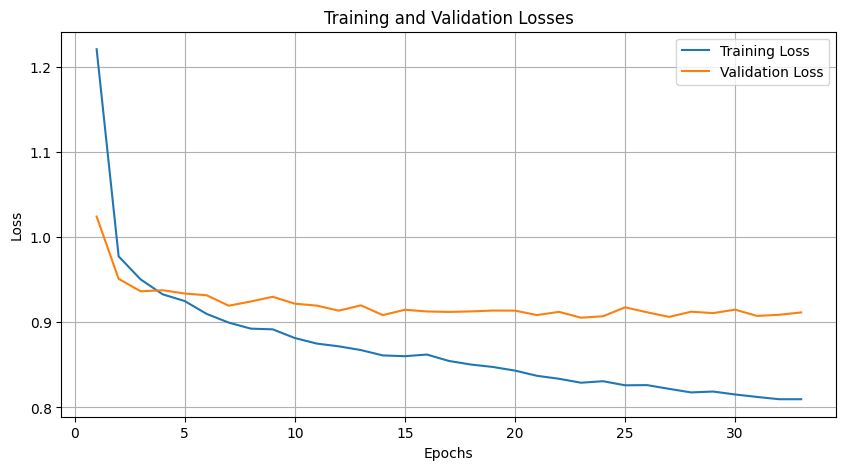

In [15]:
# Plot Losses
epochs = len(val_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [16]:
len(val_ious)

33

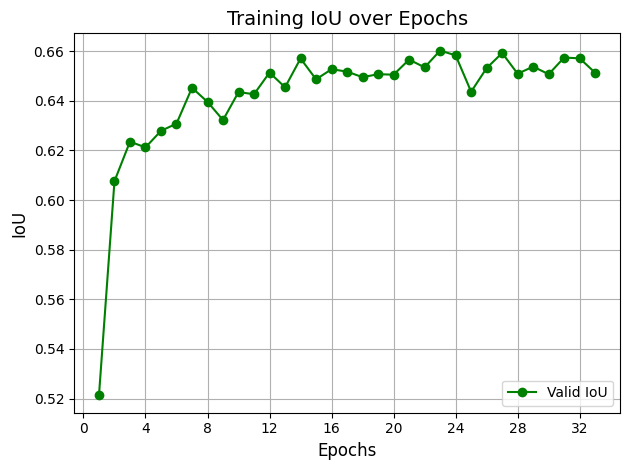

In [17]:
from matplotlib.ticker import MaxNLocator
plt.plot(list(range(1, len(val_ious) + 1)), val_ious, label='Valid IoU', color='green', linestyle='-', marker='o')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('IoU', fontsize=12)
plt.title('Training IoU over Epochs', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# 3.Evaluate your model using the test images

In [18]:
import torch
from tqdm import tqdm

import torch
from tqdm import tqdm
from sklearn.metrics import f1_score

def compute_dice_score(preds, targets, smooth=1e-6):
    """
    Compute Dice score for a batch of predictions and targets.

    Args:
        preds (torch.Tensor): Predicted masks (binarized), shape [B, 1, H, W].
        targets (torch.Tensor): Ground truth masks, shape [B, 1, H, W].
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        float: Average Dice score for the batch.
    """
    preds = preds.contiguous()
    targets = targets.contiguous()

    intersection = (preds * targets).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + smooth)
    return dice.mean().item()  # Return average Dice score for the batch


def evaluate_test_metrics(model, test_loader, device="cuda"):
    """
    Evaluate test metrics including IOU, F1 Score, and Dice Score.

    Args:
        model (torch.nn.Module): Trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (str): Device to run the model on ("cuda" or "cpu").
    
    Returns:
        dict: A dictionary containing average IOU, F1 Score, and Dice Score.
    """
    model.eval()  # Set the model to evaluation mode
    total_iou = 0.0
    total_f1 = 0.0
    total_dice = 0.0
    num_batches = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for images, masks in tqdm(test_loader, desc="Evaluating Test Metrics"):
            images, masks = images.to(device), masks.to(device)

            # Add a channel dimension to masks if necessary
            if len(masks.shape) == 3:  # [B, H, W] -> [B, 1, H, W]
                masks = masks.unsqueeze(1)

            # Forward pass
            outputs = model(images)

            # Binarize predictions (threshold = 0.5)
            preds = (outputs > 0.5).float()

            # Compute IOU for the batch
            batch_iou = compute_iou(preds, masks)
            total_iou += batch_iou

            # Compute Dice score for the batch
            batch_dice = compute_dice_score(preds, masks)
            total_dice += batch_dice

            # Compute F1 score for the batch
            preds_flat = preds.cpu().numpy().astype(int).reshape(-1)  # Flatten to 1D
            masks_flat = masks.cpu().numpy().astype(int).reshape(-1)  # Flatten to 1D
            batch_f1 = f1_score(masks_flat, preds_flat, zero_division=1)
            total_f1 += batch_f1

            num_batches += 1

    # Calculate average metrics over all batches
    avg_iou = total_iou / num_batches if num_batches > 0 else 0.0
    avg_dice = total_dice / num_batches if num_batches > 0 else 0.0
    avg_f1 = total_f1 / num_batches if num_batches > 0 else 0.0

    print(f"Average Test IOU: {avg_iou:.4f}")
    print(f"Average Test Dice Score: {avg_dice:.4f}")
    print(f"Average Test F1 Score: {avg_f1:.4f}")

    return {
        "iou": avg_iou,
        "dice": avg_dice,
        "f1": avg_f1
    }


test_metrics = evaluate_test_metrics(model, data_loader_test, device=device)
print("Test Metrics:", test_metrics)

Evaluating Test Metrics: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]

Average Test IOU: 0.6441
Average Test Dice Score: 0.7632
Average Test F1 Score: 0.7528
Test Metrics: {'iou': 0.6441071723636828, 'dice': 0.7631930944166685, 'f1': 0.75282342971582}


### Visualization of Results

In [19]:
def display_images(images, masks, preds, index=0):

    image = images[index].cpu().permute(1, 2, 0).numpy()
    mask = masks[index].cpu().squeeze().numpy()
    pred = preds[index].cpu().squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

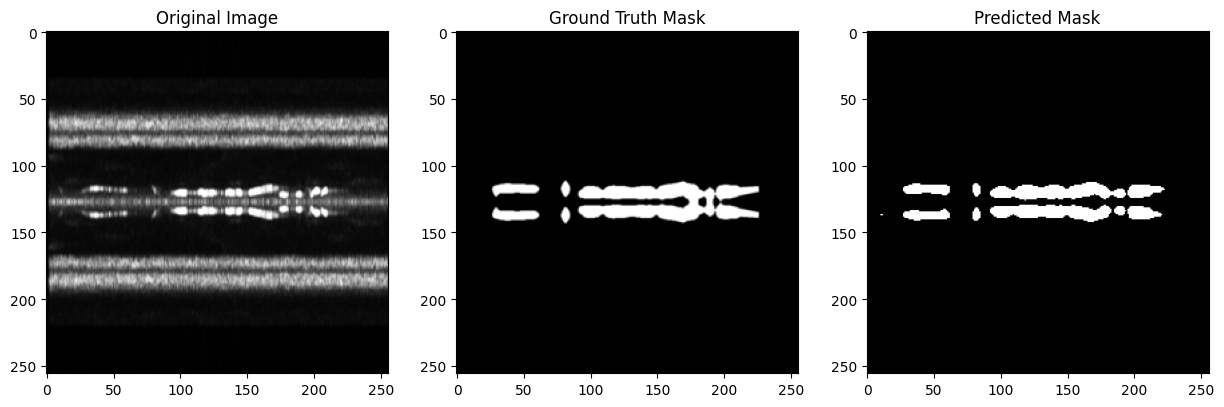

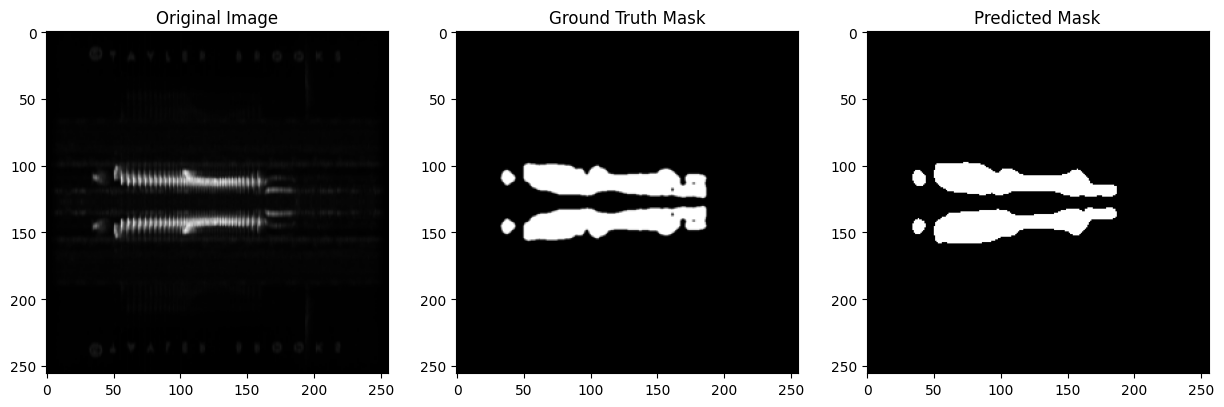

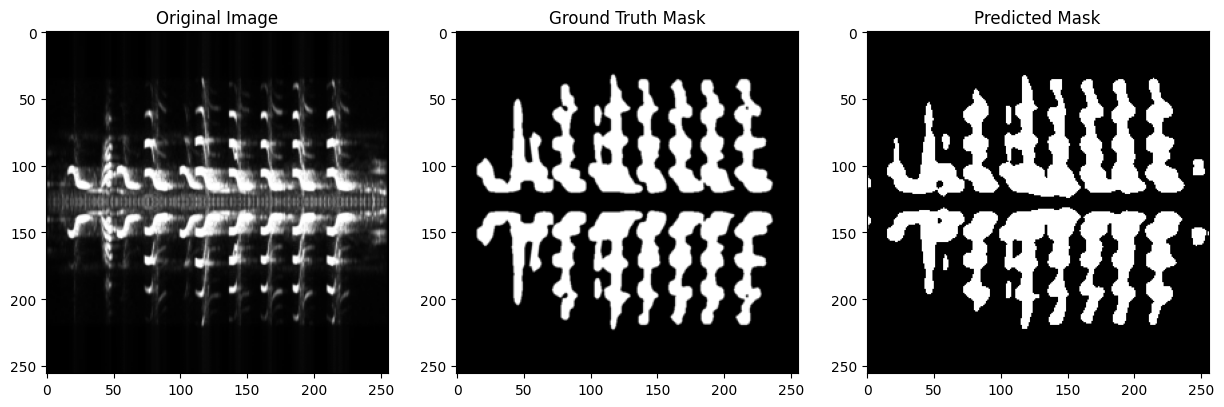

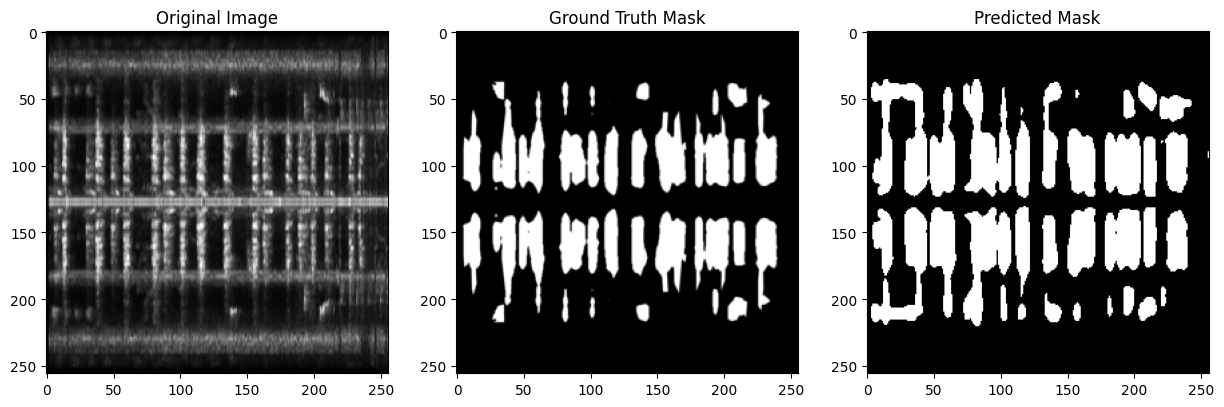

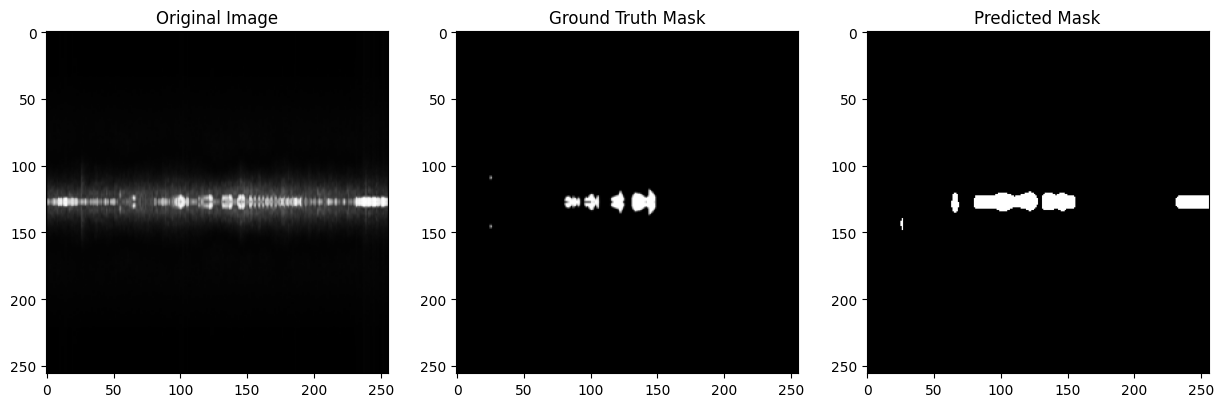

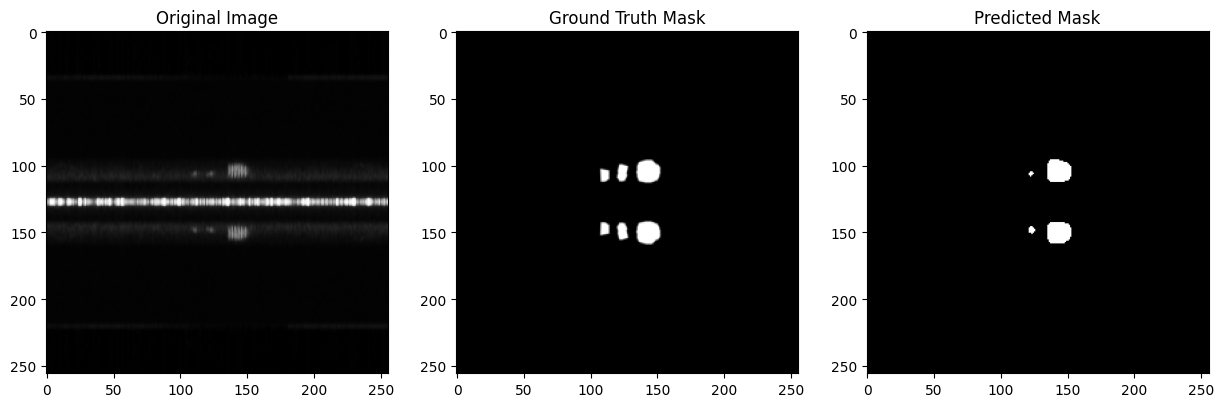

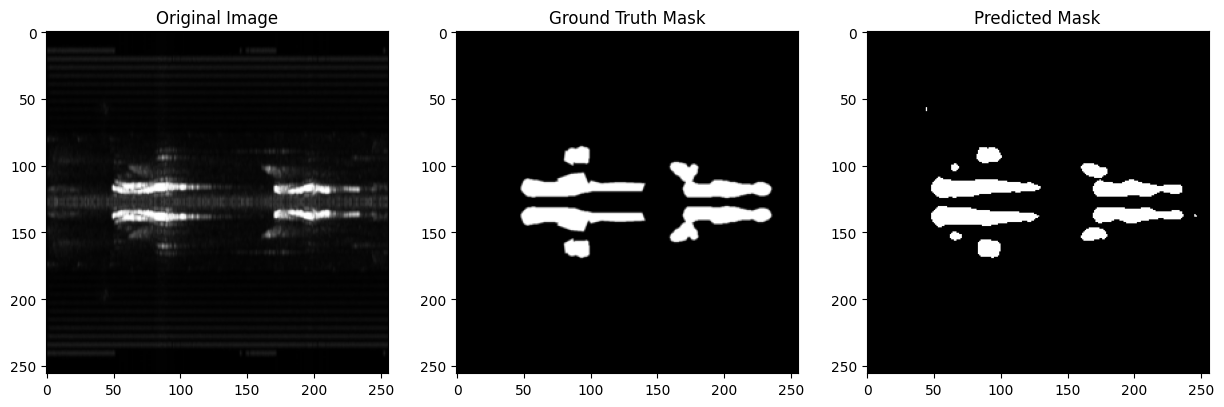

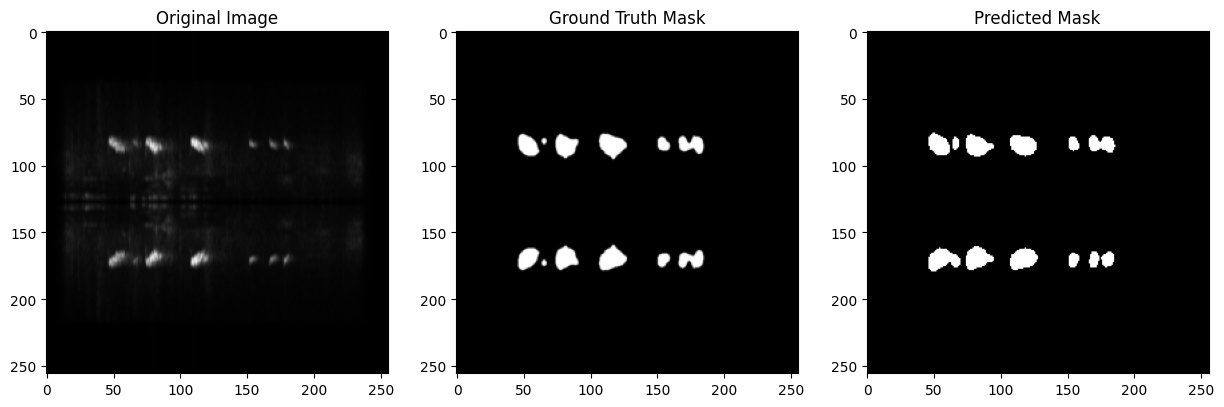

In [20]:


# Function to display the image, ground truth mask, and predicted mask
def display_predictions(images, true_masks, pred_masks, idx):
    to_pil = ToPILImage()
    for i in range(len(images)):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(to_pil(images[i].cpu()),cmap='gray')
        axs[0].set_title('Original Image')
        axs[1].imshow(to_pil(true_masks[i].cpu()),cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[2].imshow(to_pil(pred_masks[i].cpu()),cmap='gray')
        axs[2].set_title('Predicted Mask')
        plt.savefig(f'comparison_{idx}_{i}.png')
        plt.show()

# Evaluate the model and display results
with torch.no_grad():
    for idx, (images, masks) in enumerate(data_loader_test):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        pred_masks = torch.sigmoid(outputs)
        pred_masks = (pred_masks > 0.5).float()
        
        # Display the images, ground truth masks, and predicted masks
        display_predictions(images, masks, pred_masks, idx)

        # To display only one batch, break after the first iteration
        break


# 4. Your IoU score should be higher than 60

This model achieved an IoU score of 64.41%

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


### Research Paper Link:

https://www.researchgate.net/publication/386735233_Visual_Bird_Sound_Denoising_Using_Advanced_Image_Segmentation_Techniques

### Source Code / Weights Link:

https://github.com/Namrata-Patel/bird-denoising.git

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.85 -->10 points
     < 0.8  --> 0 points
     >= 0.8 & < 0.85  --> 2 point/0.01 higher
     

(6). Discussion - 10 points